# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
#!mkdir cifar10
#!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_val = X_test
y_val = y_test

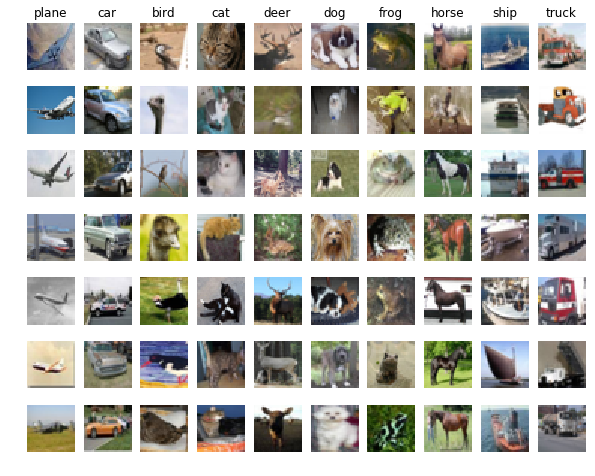

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne import init
from lasagne.layers import batch_norm
input_X = T.tensor4("X", dtype='float32')
target_y = T.vector("target Y integer",dtype='int32')

Using cuDNN version 5005 on context None
Preallocating 1603/2004 Mb (0.800000) on cuda0
Mapped name None to device cuda0: GeForce GT 740M (0000:01:00.0)


In [13]:

#1
net = batch_norm(lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X))

#2
net = batch_norm(lasagne.layers.Conv2DLayer(net, 16, 3, pad=1, nonlinearity=lasagne.nonlinearities.leaky_rectify))
net = lasagne.layers.DropoutLayer(net, 0.5)
#3
net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2), stride=2)

#2
net = batch_norm(lasagne.layers.Conv2DLayer(net, 32, 3, pad=1, nonlinearity=lasagne.nonlinearities.leaky_rectify))
net = lasagne.layers.DropoutLayer(net, 0.5)
#3
net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2), stride=2)
#4
net = batch_norm(lasagne.layers.Conv2DLayer(net, 64, 3, pad=1, nonlinearity=lasagne.nonlinearities.leaky_rectify))
#5
net = lasagne.layers.DropoutLayer(net, 0.5)
net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2), stride=2)
#6
net = batch_norm(lasagne.layers.Conv2DLayer(net, 128, 3, pad=1, nonlinearity=lasagne.nonlinearities.leaky_rectify))
#7
net = lasagne.layers.DropoutLayer(net, 0.5)

net = lasagne.layers.DenseLayer(net,num_units = 10, nonlinearity=softmax)


In [14]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b]


In [15]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [16]:
updates = lasagne.updates.adam(loss, all_weights, learning_rate=0.01)
#updates = lasagne.updates.adadelta(loss, all_weights, learning_rate=0.01)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [17]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [18]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 10 took 50.828s
  training loss (in-iteration):		1.889280
  train accuracy:		36.18 %
  validation accuracy:		46.75 %
Epoch 2 of 10 took 52.212s
  training loss (in-iteration):		1.378866
  train accuracy:		50.09 %
  validation accuracy:		52.96 %
Epoch 3 of 10 took 53.215s
  training loss (in-iteration):		1.225674
  train accuracy:		56.23 %
  validation accuracy:		57.56 %
Epoch 4 of 10 took 52.458s
  training loss (in-iteration):		1.128782
  train accuracy:		59.63 %
  validation accuracy:		59.60 %
Epoch 5 of 10 took 52.003s
  training loss (in-iteration):		1.071873
  train accuracy:		61.56 %
  validation accuracy:		61.74 %
Epoch 6 of 10 took 52.752s
  training loss (in-iteration):		1.023539
  train accuracy:		63.69 %
  validation accuracy:		62.15 %
Epoch 7 of 10 took 53.485s
  training loss (in-iteration):		0.990416
  train accuracy:		65.06 %
  validation accuracy:		64.39 %
Epoch 8 of 10 took 53.799s
  training loss (in-iteration):		0.964870
  train accuracy:		66.02 %
  valida

In [19]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 10 took 50.893s
  training loss (in-iteration):		0.905047
  train accuracy:		67.95 %
  validation accuracy:		67.07 %
Epoch 2 of 10 took 52.264s
  training loss (in-iteration):		0.887348
  train accuracy:		68.68 %
  validation accuracy:		67.42 %
Epoch 3 of 10 took 52.741s
  training loss (in-iteration):		0.871976
  train accuracy:		69.27 %
  validation accuracy:		67.80 %
Epoch 4 of 10 took 52.431s
  training loss (in-iteration):		0.861601
  train accuracy:		69.65 %
  validation accuracy:		67.71 %
Epoch 5 of 10 took 51.688s
  training loss (in-iteration):		0.857136
  train accuracy:		69.79 %
  validation accuracy:		68.06 %
Epoch 6 of 10 took 52.305s
  training loss (in-iteration):		0.844750
  train accuracy:		70.26 %
  validation accuracy:		68.53 %
Epoch 7 of 10 took 54.236s
  training loss (in-iteration):		0.832556
  train accuracy:		70.75 %
  validation accuracy:		68.32 %
Epoch 8 of 10 took 53.730s
  training loss (in-iteration):		0.825349
  train accuracy:		70.84 %
  valida

In [20]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 10 took 50.863s
  training loss (in-iteration):		0.811112
  train accuracy:		71.54 %
  validation accuracy:		68.64 %
Epoch 2 of 10 took 52.577s
  training loss (in-iteration):		0.801635
  train accuracy:		71.79 %
  validation accuracy:		69.65 %
Epoch 3 of 10 took 53.939s
  training loss (in-iteration):		0.793320
  train accuracy:		71.88 %
  validation accuracy:		69.41 %
Epoch 4 of 10 took 54.080s
  training loss (in-iteration):		0.797110
  train accuracy:		71.98 %
  validation accuracy:		69.79 %
Epoch 5 of 10 took 53.229s
  training loss (in-iteration):		0.792048
  train accuracy:		72.20 %
  validation accuracy:		68.87 %
Epoch 6 of 10 took 53.553s
  training loss (in-iteration):		0.782075
  train accuracy:		72.62 %
  validation accuracy:		69.67 %
Epoch 7 of 10 took 53.590s
  training loss (in-iteration):		0.775320
  train accuracy:		72.58 %
  validation accuracy:		69.08 %
Epoch 8 of 10 took 53.483s
  training loss (in-iteration):		0.777333
  train accuracy:		72.94 %
  valida

In [21]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 10 took 49.218s
  training loss (in-iteration):		0.764207
  train accuracy:		73.30 %
  validation accuracy:		69.79 %
Epoch 2 of 10 took 51.834s
  training loss (in-iteration):		0.762752
  train accuracy:		73.21 %
  validation accuracy:		70.06 %
Epoch 3 of 10 took 51.664s
  training loss (in-iteration):		0.761786
  train accuracy:		73.40 %
  validation accuracy:		71.23 %
Epoch 4 of 10 took 53.231s
  training loss (in-iteration):		0.752215
  train accuracy:		73.47 %
  validation accuracy:		70.60 %
Epoch 5 of 10 took 52.617s
  training loss (in-iteration):		0.747552
  train accuracy:		73.76 %
  validation accuracy:		70.28 %
Epoch 6 of 10 took 52.447s
  training loss (in-iteration):		0.752767
  train accuracy:		73.37 %
  validation accuracy:		70.87 %
Epoch 7 of 10 took 53.397s
  training loss (in-iteration):		0.744779
  train accuracy:		73.80 %
  validation accuracy:		70.33 %
Epoch 8 of 10 took 51.731s
  training loss (in-iteration):		0.743114
  train accuracy:		73.93 %
  valida

In [22]:
import time

num_epochs = 240 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 240 took 51.383s
  training loss (in-iteration):		0.740877
  train accuracy:		73.88 %
  validation accuracy:		70.40 %
Epoch 2 of 240 took 53.713s
  training loss (in-iteration):		0.731457
  train accuracy:		74.30 %
  validation accuracy:		71.44 %
Epoch 3 of 240 took 52.297s
  training loss (in-iteration):		0.734817
  train accuracy:		74.10 %
  validation accuracy:		70.08 %
Epoch 4 of 240 took 54.001s
  training loss (in-iteration):		0.726335
  train accuracy:		74.32 %
  validation accuracy:		70.55 %
Epoch 5 of 240 took 54.125s
  training loss (in-iteration):		0.726802
  train accuracy:		74.51 %
  validation accuracy:		71.03 %
Epoch 6 of 240 took 52.771s
  training loss (in-iteration):		0.725924
  train accuracy:		74.20 %
  validation accuracy:		69.89 %
Epoch 7 of 240 took 52.951s
  training loss (in-iteration):		0.722915
  train accuracy:		74.60 %
  validation accuracy:		70.41 %
Epoch 8 of 240 took 54.815s
  training loss (in-iteration):		0.722993
  train accuracy:		74.44 %


KeyboardInterrupt: 

In [12]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		68.37 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 